# DogFaceNet version 2

### Imports

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

import os
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

In [2]:
PATH = '../data/dogfacenet/'
PATH_IMAGES = PATH + 'images/'
PATH_RESIZED = PATH + 'resized/'

# Size of the input image into the network
SIZE = (100,100,3)

TEST_SPLIT = 0.05
VALID_SPLIT = 0.1

BATCH_SIZE = 64

### Dataset preprocessing
- Get the dataset from folders
- Associate the corresponding classes
- Resized the dataset
- Shuffle the dataset?
- Divide the dataset into validation, training and testing?

In [3]:
def square_crop(image):
    """
    Takes the largest between height and width of the image and crops it into a square.
    This square is located in the middle of the image.
    """
    
    h,w,c = image.shape
    
    if w > h:
        margin = w - h
        margin = margin // 2
        image = image[:,margin:margin+h,:]
    elif w < h:
        margin = h - w
        margin = margin // 2
        image = image[margin:margin+w,:,:]
    return image

Resize pictures

In [7]:
w, h, c = SIZE

label = 0

filenames = os.listdir(PATH_IMAGES)

# Just save the pictures after resizing them
for i in tqdm_notebook(range(598+869,len(filenames))):
    for file in os.listdir(PATH_IMAGES + filenames[i]):
        label += 1
        
        # Read and resized image
        image = sk.io.imread(PATH_IMAGES + filenames[i] + '/' + file)
        if len(image.shape) == 3:
            image_cropped = square_crop(image)
            image_resized = sk.transform.resize(image_cropped,SIZE)

            # Save image
            ## Check if the good folder exists
            if filenames[i] not in os.listdir(PATH_RESIZED):
                os.mkdir(PATH_RESIZED + filenames[i])
            sk.io.imsave(PATH_RESIZED + filenames[i] + '/' + str(label) + '.jpg', image_resized)

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

c:\users\guillaume\anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\users\guillaume\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\guillaume\anaconda3\lib\site-packages\skimage\util\dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Load dataset into memory

In [48]:
filenames = os.listdir(PATH_RESIZED)

i = 0

# Remove unique examples
while i<len(filenames):
    files = os.listdir(PATH_RESIZED + filenames[i])
    if len(files)<=1:
        filenames = filenames[:i] + filenames[i+1:]
    else:
        i += 1

# Compute the number of images
nbof_images = 0
for i in range(0,len(filenames)):
    files = os.listdir(PATH_RESIZED + filenames[i])
    nbof_images += len(files)

print("Number of images: " + str(nbof_images))
    
w, h, c = SIZE

images = np.empty((nbof_images,w,h,c))
labels = np.empty(nbof_images, dtype=int)

label = 0

index = 0

# Load images into numpy arrays
for i in tqdm_notebook(range(len(filenames))):
    files = os.listdir(PATH_RESIZED + filenames[i])
    for file in files:
        labels[index] = label
        # Read image
        image = sk.io.imread(PATH_RESIZED + filenames[i] + '/' + file)

        # Add the image to the table
        images[index] = image
        
        index += 1
    label += 1

# Normalize images:
images -= 127.5
images *= 1/128
assert len(labels)==len(images)

Number of images: 5568


HBox(children=(IntProgress(value=0, max=1477), HTML(value='')))

#### Old method!

Divide the dataset into train, valid and test:

To create the validation dataset we use pictures of dogs were there is more than 3 pictures and took one of this picture.

For the testing dataset we simply split the classes. We will then use the network as a one shot learner on this new dataset. With one picture the network will produce one embedding vector. For each embedding vector compute the L2 distance with each face to compute the most propable one

In [77]:
w, h, c = SIZE

nbof_test = int(len(images)*TEST_SPLIT)

images_test = images[:nbof_test]
labels_test = labels[:nbof_test]


# Count valid images:
state = -1
count_valid = 0
count_train = 0
count_image_class = 0

for i in range(nbof_test,len(labels)):
    if state != labels[i]:
        state = labels[i]
        count_image_class = 0
    else:
        count_image_class += 1
    
    if count_image_class == 3:
        count_valid += 1
    else:
        count_train += 1

print("Total number of images: " + str(len(labels)))
print("Number of test images: " + str(len(labels_test)))
print("Number of validation images: " + str(count_valid))
print("Number of training images: " + str(count_train))

images_valid = np.empty((count_valid,w,h,c))
labels_valid = np.empty(count_valid)

images_train = np.empty((count_train,w,h,c))
labels_train = np.empty(count_train)

state = -1
count_valid = 0
count_train = 0
count_image_class = 0

for i in range(nbof_test,len(labels)):
    if state != labels[i]:
        state = labels[i]
        count_image_class = 0
    else:
        count_image_class += 1
    
    if count_image_class == 3:
        # Add the validation image in the validation array
        images_valid[count_valid] = images[i]
        labels_valid[count_valid] = labels[i]
        
        count_valid += 1
    else:
        images_train[count_train] = images[i]
        labels_train[count_train] = labels[i]
        
        count_train += 1
# print(labels)
# print(labels_test)
# print(labels_train)
# print(labels_valid)
print("Is the number of images coherent? " + str(len(labels)==(len(labels_test)+len(labels_train)+len(labels_valid))))

Total number of images: 5568
Number of test images: 278
Number of validation images: 543
Number of training images: 4747


TypeError: only size-1 arrays can be converted to Python scalars

#### New method
- We divide the validation and test set from the training set with the classic division method: 85 percent training, 10 validating, 5 testing.
- We then computes pairs of images in the validation set and testing set:
 - Some of these pairs are images of the same dog and some are picture of different dogs
 - We create a two lists:
  - A list a images containing the pairs: two successive images are a pair of images. For example, image 0 and is a pair, image 2 and 3 is another pair, etc...
  - A list of boolean called 'issame' indicating if a pair is a pair of images of the same dog or a pair of different dogs. For example, if image 0 and image 1 are showing the same dog value 0 and 1 in the list will be True. On the other hand if the image 2 and 3 represent two different dogs the value 2 and 3 in the list will be at False

In [49]:
w, h, c = SIZE

nbof_test = int(len(images)*TEST_SPLIT)

images_test = images[-nbof_test:]
labels_test = labels[-nbof_test:]

nbof_valid = int(len(images)*VALID_SPLIT)

images_valid = images[-nbof_test-nbof_valid:-nbof_test]
labels_valid = labels[-nbof_test-nbof_valid:-nbof_test]

images_train = images[:-nbof_test-nbof_valid]
labels_train = labels[:-nbof_test-nbof_valid]

print("Total number of images: " + str(len(labels)))
print("Number of test images: " + str(len(labels_test)))
print("Number of validation images: " + str(len(labels_valid)))
print("Number of training images: " + str(len(labels_train)))
print("Number of classes in the training set: " + str(labels_train[-1] - labels_train[0]))


# Creates the pairs

nbof_pairs = (len(images_valid)//2)*2 # it has to be multiple of 2

print("Number of pairs: " + str(nbof_pairs))

pairs = np.empty((nbof_pairs,w,h,c))
issame_in = np.empty(nbof_pairs, dtype=int)
issame_out = np.empty((nbof_pairs,2))

nbof_same = 0

for i in range(0,nbof_pairs,2):
    ## alea_issame will decide if the new pair will be a pair of same dog images or a pair of different
    alea_issame = np.random.rand()

    if alea_issame < 0.5: # Then it will be a pair of same dogs
        # we randomly choose a dog
        choice = np.random.randint(len(labels_valid))
        
        # we extract the images of this class
        chosen_images = list(images_valid[np.equal(labels_valid,labels_valid[choice])])
        
        while len(labels_valid[np.equal(labels_valid,labels_valid[choice])]) < 2:
            choice = np.random.randint(len(labels_valid))
            chosen_images = list(images_valid[np.equal(labels_valid,labels_valid[choice])])
            
        # we then randomly choose two pictures of this class
        choice1 = np.random.randint(len(chosen_images))
        pairs[i] = chosen_images[choice1]
        save = np.copy(chosen_images)
        chosen_images = chosen_images[:choice1] + chosen_images[choice1+1:]
        if len(chosen_images) == 0:
            print("Bug!")
            print(save)
        choice2 = np.random.randint(len(chosen_images))
        pairs[i+1] = chosen_images[choice2]

        issame_out[i] = issame_out[i+1] = [1,0]
        issame_in[i] = issame_in[i+1] = 1
        
        nbof_same += 1
        
    else: # Then it will be a pair of different dogs
        # we randomly choose two dogs
        choice1 = np.random.randint(len(labels_valid))
        
        # we extract the images of the class
        chosen_images = list(images_valid[np.equal(labels_valid,labels_valid[choice1])])
        
        # we choose an image of this class
        choice = np.random.randint(len(chosen_images))
        #print(choice)
        pairs[i] = images_valid[choice]
        
        choice2 = np.random.randint(len(labels_valid))
        
        # check if we have two different classes
        while labels_valid[choice2] == labels_valid[choice1]:
            choice2 = np.random.randint(len(labels_valid))
        
        chosen_images = list(images_valid[np.equal(labels_valid,labels_valid[choice2])])
        
        # we choose an image of this class
        choice = np.random.randint(len(chosen_images))
        
        pairs[i+1] = images_valid[choice]
        
        issame_out[i] = issame_out[i+1] = [0,1]
        issame_in[i] = issame_in[i+1] = 0

print("Number of same images: " + str(nbof_same))
print("Number of validation images: " + str(len(labels_valid)))

Total number of images: 5568
Number of test images: 278
Number of validation images: 556
Number of training images: 4734
Number of classes in the training set: 1300
Number of pairs: 556
Number of same images: 149
Number of validation images: 556


In [50]:
NBOF_CLASSES = max(labels_train)+1
#labels_train = tf.keras.utils.to_categorical(labels_train,NBOF_CLASSES)
#labels_valid = tf.keras.utils.to_categorical(labels_valid-NBOF_CLASSES,NBOF_CLASSES)
issame_train_in = np.ones(len(labels_train))
issame_train_out = np.zeros((len(labels_train),2))
issame_train_out[:,0] = 1

In [9]:
# Verify shapes
# Train inputs
print("Train input shapes: ")
print(images_train.shape)
print(labels_train.shape)
print(issame_train_in.shape)

print("Train output shape: ")
print(labels_train.shape)
print(issame_train_out.shape)

print("Valid input shape: ")
print(images_valid.shape)
print(labels_valid.shape)
print(issame_in.shape)

print("Valid output shape: ")
print(labels_valid.shape)
print(issame_out.shape)

Train input shapes: 
(4734, 100, 100, 3)
(4734,)
(4734,)
Train output shape: 
(4734,)
(4734, 2)
Valid input shape: 
(556, 100, 100, 3)
(556,)
(556,)
Valid output shape: 
(556,)
(556, 2)


### Define the model
- Define the ArcFace layer
- Define the dummy model first
- Compile it with the softmax loss and and Adam optimizer
- Then use transfer learning with a more complex model

Define the Arcface layer

In [14]:
mask = tf.one_hot(tf.constant([1,2,2,3]),4)
with tf.Session() as sess:
    mask_ = sess.run(mask)
    print(mask_)

[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [6]:
# My custom layer for arcface
# It takes two inputs: one for the embedding, one for the label

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
import math

# Arcface should only be used for training
class Arcface(Layer):

    def __init__(self, out_num, s = 64., m = 0.5, **kwargs):
        self.out_num = out_num
        self.s = s
        self.m = m
        super(Arcface, self).__init__(**kwargs)

    def build(self, input_shape, initializer='uniform'):
        assert isinstance(input_shape, list)
        
        shape = tf.TensorShape((input_shape[0][-1],self.out_num))
        print(shape)
        
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel',
                                                 shape=shape,
                                                 initializer=initializer,
                                                 dtype=tf.float32,
                                                 trainable=True)
        super(Arcface, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        assert isinstance(x, list)
        embedding, labels = x
        
        cos_m = math.cos(self.m)
        sin_m = math.sin(self.m)
        mm = sin_m * self.m  # issue 1
        threshold = math.cos(math.pi - self.m)
        
        # inputs and weights norm
        embedding_norm = tf.norm(embedding, axis=1, keepdims=True)
        embedding = tf.div(embedding, embedding_norm, name='norm_embedding')
        
        weights_norm = tf.norm(self.kernel, axis=0, keepdims=True)
        weights = tf.div(self.kernel, weights_norm, name='norm_weights')
        # cos(theta+m)
        cos_t = tf.matmul(embedding, weights, name='cos_t')
        cos_t2 = tf.square(cos_t, name='cos_2')
        sin_t2 = tf.subtract(1., cos_t2, name='sin_2')
        sin_t = tf.sqrt(sin_t2, name='sin_t')
        cos_mt = self.s * tf.subtract(tf.multiply(cos_t, cos_m), tf.multiply(sin_t, sin_m), name='cos_mt')
        
        # this condition controls the theta+m should be in range [0, pi]
        #      0<=theta+m<=pi
        #     -m<=theta<=pi-m
        cond_v = cos_t - threshold
        cond = tf.cast(tf.nn.relu(cond_v, name='if_else'), dtype=tf.bool)

        keep_val = self.s*(cos_t - mm)
        cos_mt_temp = tf.where(cond, cos_mt, keep_val)

        mask = tf.one_hot(labels, depth=self.out_num, name='one_hot_mask')
        # mask = tf.squeeze(mask, 1)
        inv_mask = tf.subtract(1., mask, name='inverse_mask')

        s_cos_t = tf.multiply(self.s, cos_t, name='scalar_cos_t')

        output = tf.add(tf.multiply(s_cos_t, inv_mask), tf.multiply(cos_mt_temp, mask), name='arcface_loss_output')
        
        return output

    def compute_output_shape(self, input_shape):
        assert isinstance(input_shape, list)
        shape_emb, shape_lab = input_shape
        shape_emb[-1] = self.out_num
        return tf.TensorShape(shape_emb)
    
#         shape = tf.TensorShape(input_shape).as_list()
#         shape[-1] = self.num_classes
#         return tf.TensorShape(shape)


In [39]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
import math

# Arcface should only be used for training
class Arcface(Layer):

    def __init__(self, out_num, s = 64., m = 0.5, **kwargs):
        self.out_num = out_num
        self.s = s
        self.m = m
        super(Arcface, self).__init__(**kwargs)

    def build(self, input_shape, initializer='uniform'):
        assert isinstance(input_shape, list)
        
        shape = tf.TensorShape((input_shape[0][-1],self.out_num))
        print(shape)
        
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel',
                                                 shape=shape,
                                                 initializer=initializer,
                                                 dtype=tf.float32,
                                                 trainable=True)
        super(Arcface, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x, training=None):
        assert isinstance(x, list)
        emb, labels = x
        labels_sq = tf.squeeze(labels,1)
        #labels_sq = tf.reshape(labels,[None])
        labels_int = tf.cast(labels_sq,tf.int32, name='labels_int')
        print(labels_int.shape)
        mask = tf.one_hot(labels_int, depth=self.out_num, name='one_hot_mask')
        #mask = tf.squeeze(mask,1)
        print(mask.shape)
        #mask_shape = mask.shape.as_list()
        #mask = tf.reshape(mask, (None,mask_shape[-1]))
        #print(mask.shape)
        def train_output():
            cos_m = math.cos(self.m)
            sin_m = math.sin(self.m)
            mm = sin_m * self.m  # issue 1
            threshold = math.cos(math.pi - self.m)

            # inputs and weights norm
            embedding_norm = tf.norm(emb, axis=1, keepdims=True)
            embedding = tf.div(emb, embedding_norm, name='norm_embedding')

            weights_norm = tf.norm(self.kernel, axis=0, keepdims=True)
            weights = tf.div(self.kernel, weights_norm, name='norm_weights')
            # cos(theta+m)
            cos_t = tf.matmul(embedding, weights, name='cos_t')
            print(cos_t.shape)
            cos_t2 = tf.square(cos_t, name='cos_2')
            sin_t2 = tf.subtract(1., cos_t2, name='sin_2')
            sin_t = tf.sqrt(sin_t2, name='sin_t')
            cos_mt = self.s * tf.subtract(tf.multiply(cos_t, cos_m), tf.multiply(sin_t, sin_m), name='cos_mt')

            # this condition controls the theta+m should be in range [0, pi]
            #      0<=theta+m<=pi
            #     -m<=theta<=pi-m
            cond_v = cos_t - threshold
            cond = tf.cast(tf.nn.relu(cond_v, name='if_else'), dtype=tf.bool)

            keep_val = self.s*(cos_t - mm)
            cos_mt_temp = tf.where(cond, cos_mt, keep_val)

            
            # mask = tf.squeeze(mask, 1)
            inv_mask = tf.subtract(1., mask, name='inverse_mask')

            s_cos_t = tf.multiply(self.s, cos_t, name='scalar_cos_t')
            mul1 = tf.multiply(s_cos_t, inv_mask)
            print(mul1.shape)
            mul2 = tf.multiply(cos_mt_temp, mask)
            print(mul2.shape)
            output = tf.add(mul1, mul2, name='arcface_loss_output')
            print(output.shape)
            print(cos_mt_temp.shape)
            
            return output
        
        def valid_output():
            return mask
        
        return K.in_train_phase(train_output,valid_output,training=training)

    def compute_output_shape(self, input_shape):
        assert isinstance(input_shape, list)
        shape_emb, shape_lab = input_shape
        shape_emb[-1] = self.out_num
        return tf.TensorShape(shape_emb)

In [95]:

class MyLayer(Layer):

    def __init__(self, output_dim, s = 64., m = 0.5, **kwargs):
        self.out_num = output_dim
        self.m = m
        self.s = s
        
        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        shape = (input_shape[1].value, self.out_num)
        print(shape)
        self.kernel = self.add_weight(name='kernel', 
                                      shape=shape,
                                      initializer='uniform',
                                      trainable=True)
        super(MyLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        #assert isinstance(x, list)
        embedding = x
        
        cos_m = math.cos(self.m)
        sin_m = math.sin(self.m)
        mm = sin_m * self.m  # issue 1
        threshold = math.cos(math.pi - self.m)
        
        # inputs and weights norm
        embedding_norm = tf.norm(embedding, axis=1, keepdims=True)
        embedding = tf.div(embedding, embedding_norm, name='norm_embedding')
        
        weights_norm = tf.norm(self.kernel, axis=0, keepdims=True)
        weights = tf.div(self.kernel, weights_norm, name='norm_weights')
        #print(self.weights)
        # cos(theta+m)
        cos_t = tf.matmul(embedding, weights, name='cos_t')
        cos_t2 = tf.square(cos_t, name='cos_2')
        sin_t2 = tf.subtract(1., cos_t2, name='sin_2')
        sin_t = tf.sqrt(sin_t2, name='sin_t')
        cos_mt = self.s * tf.subtract(tf.multiply(cos_t, cos_m), tf.multiply(sin_t, sin_m), name='cos_mt')
        
        # this condition controls the theta+m should be in range [0, pi]
        #      0<=theta+m<=pi
        #     -m<=theta<=pi-m
        cond_v = cos_t - threshold
        cond = tf.cast(tf.nn.relu(cond_v, name='if_else'), dtype=tf.bool)

        keep_val = self.s*(cos_t - mm)
        cos_mt_temp = tf.where(cond, cos_mt, keep_val)

        #mask = tf.one_hot(labels, depth=self.out_num, name='one_hot_mask')
        # mask = tf.squeeze(mask, 1)
        #inv_mask = tf.subtract(1., mask, name='inverse_mask')

        
        s_cos_t = tf.multiply(self.s, cos_t, name='scalar_cos_t')
        
        return s_cos_t

    def compute_output_shape(self, input_shape):
        return (input_shape[0].value, self.output_dim)

Define the validation layer:
- The bigger the validation batch the better it is (no less than 64 pictures -> 32 pairs)
- It computes the ROC curve
- Finds the best threshold
- Returns a list of 2D vectors [1,0] if the pair was the same dog, [0,1] if it was a different dog

In [169]:
import time
# tests unitaires

tf.reset_default_graph()
emb_raw = tf.constant([[12.,2],[8,4],[3,8],[2,10],[50,10],[10,30]])

actual_issame = tf.constant([1.,1,1,1,0,0])
emb = tf.math.l2_normalize(emb_raw,0)

# Normalizes
#emb = tf.math.l2_normalize(emb_,0)

# Separates the pairs
emb1 = emb[0::2]
emb2 = emb[1::2]

# Computes distance between pairs
diff = tf.squared_difference(emb1,emb2)
dist = tf.reduce_sum(diff,1)

dist = tf.reshape(tf.stack([dist,dist], axis=-1), [-1])
print(dist.shape)
best_threshold = 0
#for t in np.arange(0,1,0.001):
t = 0.01

actual_issame_bool = tf.cast(actual_issame,dtype=tf.bool)

def fn(t):
    less = tf.less(dist,t)

    acc = tf.logical_not(tf.logical_xor(less,actual_issame_bool))
    acc = tf.cast(acc,tf.float32)
    
    out = tf.reshape(tf.reduce_sum(acc),[])
    
    return out


thresholds = tf.range(0,1,0.001)
apply_t = tf.map_fn(fn, thresholds)
best_t = tf.argmax(apply_t)

best = thresholds[best_t]

# Redo the manipulation with the best threshold
less = tf.less(dist,best)
less = tf.cast(less,tf.float32)
#less = tf.map_fn(lambda x : (1-x) * [0,1] + x * [1,0], less)


# # Creates different threshold in order to find the best one
# np_threshold = np.vstack([np.arange(0,1,0.01)]*3).T

# # Reshapes the distance
# dist2 = tf.stack([dist]*len(np_threshold))

# # Reshapes the true values
# actual_issame = tf.constant([[True,True,False]]*len(np_threshold),dtype=bool)

# threshold = tf.constant(np_threshold, dtype=tf.float32)

# # Uses the created thresholds to compute the predictions
# predict_issame = tf.less(dist2,threshold)

# # Computes the accuracy
# truth = tf.logical_not(tf.logical_xor(predict_issame, actual_issame))

# r = tf.reduce_sum(tf.cast(truth,tf.float32),1)

# # Finds the best accuracy with respect to the threshold
# m = tf.argmax(r)

# # best_threshold = threshold[m]
# # accuracy = r[m]/3

# # Ouputs the best output and reshapes the output in a softmax way
# bool_output = predict_issame[m]
# int_output = tf.cast(bool_output,tf.int32)
# output = tf.map_fn(lambda x : (1-x) * [0,1] + x * [1,0], int_output)



    
with tf.Session() as sess:
    t1 = time.time()
    dist_ = sess.run(less)
    t2 = time.time()
    print(t2-t1)
    print(dist_)

(6,)
0.6226596832275391
[1. 1. 1. 1. 0. 0.]


In [18]:
import time
# tests unitaires

tf.reset_default_graph()
emb_raw = tf.constant([[12.,2],[8,4],[3,8],[2,10],[50,10],[10,30]])
emb_ = tf.math.l2_normalize(emb_raw,0)

# Normalizes
emb = tf.math.l2_normalize(emb_,0)

# Separates the pairs
emb1 = emb[0::2]
emb2 = emb[1::2]

# Computes distance between pairs
diff = tf.squared_difference(emb1,emb2)
dist = tf.reduce_sum(diff,1)



# Creates different threshold in order to find the best one
np_threshold = np.vstack([np.arange(0,1,0.01)]*3).T

# Reshapes the distance
dist2 = tf.stack([dist]*len(np_threshold))

# Reshapes the true values
actual_issame = tf.constant([[True,True,False]]*len(np_threshold),dtype=bool)

threshold = tf.constant(np_threshold, dtype=tf.float32)

# Uses the created thresholds to compute the predictions
predict_issame = tf.less(dist2,threshold)

# Computes the accuracy
truth = tf.logical_not(tf.logical_xor(predict_issame, actual_issame))

r = tf.reduce_sum(tf.cast(truth,tf.float32),1)

# Finds the best accuracy with respect to the threshold
m = tf.argmax(r)

# best_threshold = threshold[m]
# accuracy = r[m]/3

# Ouputs the best output and reshapes the output in a softmax way
bool_output = predict_issame[m]
int_output = tf.cast(bool_output,tf.int32)
output = tf.map_fn(lambda x : (1-x) * [0,1] + x * [1,0], int_output)



    
with tf.Session() as sess:
    t1 = time.time()
    act,pred,a_ = sess.run([actual_issame,truth,output])
    t2 = time.time()
    print(t2-t1)
    print(a_)

0.14561080932617188
[[1 0]
 [1 0]
 [0 1]]


In [6]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

# Should only be used for validating
class Validation(Layer):

    def __init__(self, **kwargs):
        super(Validation, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        self.emb_shape = input_shape[0]
        super(Validation, self).build(input_shape)

    def call(self, x, training=None):
        """
        Inputs: a tuple containing the embeddings and the issame list
        - embeddings: shape=(batch_size, embedding_size), type=float
        - issame: shape=(batch_size), type=bool
        
        Outputs: a tensor of shape=(batch_size,2), the ouput is either [1,0] (is same) or [0,1] (is different)
        """
        assert isinstance(x, list)
        
        embeddings, iss = x
        
        
        
        def train_output():
            return iss
        
        def valid_output():
            issame = tf.squeeze(iss)
            #self.emb_shape = embeddings.shape
            emb = tf.math.l2_normalize(embeddings,0)
            # emb contains a list of pictures
            # pictures with an even index are first pictures of the pairs
            # pictures with an odd index are second pictures of the pairs
            emb1 = embeddings[0::2]
            emb2 = embeddings[1::2]
            #emb1, emb2 = tf.split(embeddings, [32,32],0)
            
          # Compute the distance for each pair of vector
            dist = tf.reduce_sum(tf.squared_difference(emb1,emb2),1)
            dist = tf.reshape(tf.stack([dist,dist], axis=-1), [-1])
            actual_issame_bool = tf.cast(issame,dtype=tf.bool)

            def fn(t):
                less = tf.less(dist,t)
                acc = tf.logical_not(tf.logical_xor(less,actual_issame_bool))
                acc = tf.cast(acc,tf.float32)
                out = tf.reshape(tf.reduce_sum(acc),[])
                return out


            thresholds = tf.range(0,1,0.001)
            apply_t = tf.map_fn(fn, thresholds)
            best_t = tf.argmax(apply_t)

            best = thresholds[best_t]

          # Redo the manipulation with the best threshold
            less = tf.less(dist,0.01)
            less = tf.cast(less,tf.float32)
            less = tf.expand_dims(less,1) # <- bug fixed
            return less

            
        return K.in_train_phase(train_output,valid_output,training=training)

    def compute_output_shape(self, input_shape):
        assert isinstance(input_shape, list)
        emb_shape, _ = input_shape
        return (emb_shape[0], 1)

In [145]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

# Dummy layers to try the testing/training phases
class test(Layer):

    def __init__(self, **kwargs):
        super(test, self).__init__(**kwargs)

    def build(self, input_shape):
        super(test, self).build(input_shape)

    def call(self, x, training=None):
        
        def train_output():
            ret = tf.multiply(x,0.)
            ret = tf.add(ret,1.)
            #ret.set_shape(x.get_shape())
            return ret
        
        def valid_output():
            ret = tf.zeros_like(x)
            return ret
            
        return K.in_train_phase(train_output,valid_output,training=training)

    def compute_output_shape(self, input_shape):
        return input_shape

In [13]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

# Dummy layers to try the testing/training phases
class test(Layer):

    def __init__(self, **kwargs):
        super(test, self).__init__(**kwargs)

    def build(self, input_shape):
        super(test, self).build(input_shape)

    def call(self, y, training=None):
        
        x,iss = y
        def train_output():
            #ret = tf.multiply(x,0.)
            #ret = tf.add(ret,1.)
            #ret.set_shape(x.get_shape())
            ret = iss
            #ret.set_shape((iss.get_shape()[0],2))
            return ret
        
        def valid_output():
            ret = tf.zeros_like(iss)
            return ret
            
        return K.in_train_phase(train_output,valid_output,training=training)

    def compute_output_shape(self, input_shape):
        return input_shape

Define the model

In [ ]:
class Dummiest(tf.keras.Model):
    def __init__(self, emb_size = 32):
        """
        -emb_size: size of the embedding
        -out_num: number of identities in the 
        """
        super(EvenMoreDummy, self).__init__(name='even_more_dummy')
        self.conv1 = tf.keras.layers.Conv2D(10,(3, 3))
        self.pool1 = tf.keras.layers.MaxPooling2D((2, 2))
        self.conv2 = tf.keras.layers.Conv2D(20,(3, 3))
        self.pool2 = tf.keras.layers.MaxPooling2D((2, 2))
        self.conv3 = tf.keras.layers.Conv2D(40,(3, 3))
        self.pool3 = tf.keras.layers.MaxPooling2D((2, 2))
        self.avg_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.dense = tf.layers.Dense(emb_size)
        self.f = tf.layers.Dense(1301, name='out')
    
    def call(self, images, training=None):
        
        x = self.conv1(images)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.avg_pool(x)
        emb = tf.math.l2_normalize(x)
        
        return self.f(emb)

model = Dummiest(32)
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### tests unitaires

In [146]:
#tf.reset_default_graph()
class EvenMoreDummy(tf.keras.Model):
    def __init__(self, emb_size = 32):
        """
        -emb_size: size of the embedding
        -out_num: number of identities in the 
        """
        super(EvenMoreDummy, self).__init__(name='even_more_dummy')
        self.conv1 = tf.keras.layers.Conv2D(10,(3, 3))
        self.pool1 = tf.keras.layers.MaxPooling2D((2, 2))
        self.conv2 = tf.keras.layers.Conv2D(20,(3, 3))
        self.pool2 = tf.keras.layers.MaxPooling2D((2, 2))
        self.conv3 = tf.keras.layers.Conv2D(40,(3, 3))
        self.pool3 = tf.keras.layers.MaxPooling2D((2, 2))
        self.avg_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.dense = tf.layers.Dense(emb_size)
        self.drop = tf.keras.layers.Dropout(0.5)
        self.f = tf.layers.Dense(1301, name='out')
        self.test = test()
    
    def call(self, images, training=None):
        
        x = self.conv1(images)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.avg_pool(x)
        x = self.dense(x)
        x = self.drop(x)
        emb = tf.math.l2_normalize(x)
        emb = self.f(emb)
        emb = self.test(emb)

        return emb

model = EvenMoreDummy(32)
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='mse',
              metrics=['accuracy'])

In [56]:
# Try to use the functional API
tf.reset_default_graph()
def net(inputs_shapes, emb_size=32):
    images_shape, labels_shape, issame_shape = inputs_shapes
    input_image = tf.keras.Input(images_shape,name='image_input')
    x = tf.keras.layers.Conv2D(10,(3, 3))(input_image)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(20,(3, 3))(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(40,(3, 3))(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    emb = tf.keras.layers.Dense(emb_size, activity_regularizer='l2')(x)
    #out = tf.keras.layers.Dense(1301, name='arcface')(emb)
    
    input_labels = tf.keras.Input(labels_shape,name='input_labels')
    out = Arcface(1301, name='arcface')([emb,input_labels])
                                         
    input_issame = tf.keras.Input(issame_shape,name='issame_input')
    valid = Validation(name='validation')([emb,input_issame])
    
    return tf.keras.Model(inputs=[input_image,input_labels,input_issame], outputs=[out,valid])

w, h, c = SIZE
inputs_shapes = [(w, h, c,),(1,),(1,)]
model = net(inputs_shapes)
model.compile(tf.train.AdamOptimizer(),loss={'arcface':'mse','validation':'binary_crossentropy'},metrics=['accuracy'])

(32, 1301)
(?,)
(?, 1301)
(?, 1301)
(?, 1301)
(?, 1301)
(?, 1301)
(?, 1301)


### Train it

In [32]:
labels_train_out = tf.keras.utils.to_categorical(labels_train,NBOF_CLASSES)

In [102]:
labels_train.shape

(4734,)

In [140]:
labels_train = np.ones(labels_train.shape)
labels_train

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [33]:
labels_valid_out = tf.keras.utils.to_categorical(labels_valid-NBOF_CLASSES,NBOF_CLASSES)

In [91]:
labels_valid

array([1300, 1300, 1300, 1301, 1301, 1301, 1301, 1301, 1302, 1302, 1302,
       1302, 1302, 1302, 1302, 1303, 1303, 1303, 1303, 1303, 1303, 1304,
       1304, 1304, 1304, 1305, 1305, 1305, 1306, 1306, 1306, 1307, 1307,
       1308, 1308, 1309, 1309, 1309, 1310, 1310, 1310, 1311, 1311, 1311,
       1312, 1312, 1313, 1313, 1314, 1314, 1314, 1315, 1315, 1315, 1315,
       1315, 1315, 1315, 1315, 1316, 1316, 1316, 1317, 1317, 1317, 1317,
       1318, 1318, 1318, 1318, 1318, 1319, 1319, 1319, 1319, 1319, 1319,
       1319, 1320, 1320, 1321, 1321, 1321, 1322, 1322, 1322, 1322, 1323,
       1323, 1323, 1323, 1323, 1323, 1324, 1324, 1324, 1324, 1325, 1325,
       1325, 1326, 1326, 1327, 1327, 1328, 1328, 1329, 1329, 1330, 1330,
       1330, 1330, 1330, 1331, 1331, 1331, 1332, 1332, 1332, 1332, 1333,
       1333, 1333, 1334, 1334, 1334, 1335, 1335, 1335, 1336, 1336, 1336,
       1336, 1336, 1336, 1336, 1337, 1337, 1338, 1338, 1339, 1339, 1340,
       1340, 1340, 1341, 1341, 1342, 1342, 1342, 13

In [130]:
labels_valid = np.zeros(labels_valid.shape)
labels_valid

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [51]:
# Check the inputs
print("Train inputs:")
print(images_train)
print(labels_train)
print(issame_train_in)

print("Train outputs")
print(labels_train_out)
print(issame_train_in)

print("Valid inputs")
print(images_valid)
print(labels_valid)
print(issame_in)

print("Valid outputs")
print(labels_valid_out)
print(issame_in)

Train inputs:
[[[[ 0.01171875 -0.44921875 -0.29296875]
   [ 0.05078125 -0.45703125 -0.28515625]
   [ 0.19140625 -0.39453125 -0.16015625]
   ...
   [ 0.98828125  0.99609375  0.99609375]
   [ 0.98828125  0.99609375  0.99609375]
   [ 0.98046875  0.98828125  0.99609375]]

  [[-0.14453125 -0.55859375 -0.43359375]
   [-0.13671875 -0.58203125 -0.43359375]
   [-0.04296875 -0.55078125 -0.36328125]
   ...
   [ 0.94140625  0.94921875  0.96484375]
   [ 0.96484375  0.97265625  0.98828125]
   [ 0.87890625  0.88671875  0.90234375]]

  [[-0.09765625 -0.39453125 -0.30859375]
   [-0.11328125 -0.44140625 -0.34765625]
   [-0.08984375 -0.48828125 -0.33984375]
   ...
   [ 0.98828125  0.99609375  0.99609375]
   [ 0.97265625  0.98046875  0.99609375]
   [ 0.76171875  0.76953125  0.78515625]]

  ...

  [[ 0.21484375 -0.12109375 -0.45703125]
   [ 0.09765625 -0.25390625 -0.57421875]
   [ 0.30078125 -0.07421875 -0.35546875]
   ...
   [-0.03515625  0.05078125 -0.48828125]
   [-0.01953125  0.06640625 -0.47265625]
  

   [ 0.06640625 -0.05078125 -0.38671875]]]]
[   0    0    0 ... 1299 1299 1300]
[1. 1. 1. ... 1. 1. 1.]
Train outputs
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
[1. 1. 1. ... 1. 1. 1.]
Valid inputs
[[[[ 0.78515625  0.55078125  0.28515625]
   [-0.24609375 -0.46484375 -0.75390625]
   [-0.02734375 -0.24609375 -0.53515625]
   ...
   [-0.54296875 -0.58203125 -0.73046875]
   [-0.05859375 -0.10546875 -0.23046875]
   [ 0.91015625  0.86328125  0.75390625]]

  [[ 0.68359375  0.45703125  0.19140625]
   [-0.12109375 -0.34765625 -0.61328125]
   [ 0.01171875 -0.20703125 -0.49609375]
   ...
   [-0.76953125 -0.80859375 -0.95703125]
   [-0.44921875 -0.49609375 -0.62109375]
   [ 0.83203125  0.78515625  0.67578125]]

  [[ 0.76171875  0.55859375  0.30078125]
   [-0.12109375 -0.32421875 -0.59765625]
   [ 0.10546875 -0.09765625 -0.37109375]
   ...
   [-0.79296875 -0.83984375 -0.96484375]
   [-0.5

   [-0.41796875 -0.47265625 -0.80078125]]]]
[1300 1300 1300 1301 1301 1301 1301 1301 1302 1302 1302 1302 1302 1302
 1302 1303 1303 1303 1303 1303 1303 1304 1304 1304 1304 1305 1305 1305
 1306 1306 1306 1307 1307 1308 1308 1309 1309 1309 1310 1310 1310 1311
 1311 1311 1312 1312 1313 1313 1314 1314 1314 1315 1315 1315 1315 1315
 1315 1315 1315 1316 1316 1316 1317 1317 1317 1317 1318 1318 1318 1318
 1318 1319 1319 1319 1319 1319 1319 1319 1320 1320 1321 1321 1321 1322
 1322 1322 1322 1323 1323 1323 1323 1323 1323 1324 1324 1324 1324 1325
 1325 1325 1326 1326 1327 1327 1328 1328 1329 1329 1330 1330 1330 1330
 1330 1331 1331 1331 1332 1332 1332 1332 1333 1333 1333 1334 1334 1334
 1335 1335 1335 1336 1336 1336 1336 1336 1336 1336 1337 1337 1338 1338
 1339 1339 1340 1340 1340 1341 1341 1342 1342 1342 1343 1343 1344 1344
 1344 1345 1345 1346 1346 1347 1347 1348 1348 1348 1349 1349 1350 1350
 1350 1350 1351 1351 1351 1351 1351 1352 1352 1352 1352 1352 1353 1353
 1353 1353 1354 1354 1354 1354 13

In [57]:
model.fit(
    #[images_train,issame_train_in],
    [images_train,labels_train,issame_train_in],
    #[labels_train,issame_train_out],
    #[labels_train,issame_train_out],
    [labels_train_out,issame_train_in],
    epochs=20,
    batch_size=64,
    validation_data = ([images_valid,labels_valid,issame_in], [labels_valid_out,issame_in]),
    #validation_data = ([images_valid,issame_in], labels_valid)
    #validation_data=([images_valid,labels_valid,issame_in],[labels_valid,issame_out])
    callbacks=[tf.keras.callbacks.TensorBoard(log_dir='../output/logs/')]
)

Train on 4734 samples, validate on 556 samples
Epoch 1/20


4096/4734 [========================>.....] - ETA: 1:08 - loss: 0.8264 - arcface_loss: 0.8021 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 37s - loss: 0.8284 - arcface_loss: 0.8040 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 27s - loss: 0.8279 - arcface_loss: 0.8034 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.00 - ETA: 22s - loss: 0.8275 - arcface_loss: 0.8031 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.00 - ETA: 18s - loss: 0.8278 - arcface_loss: 0.8034 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.00 - ETA: 16s - loss: 0.8284 - arcface_loss: 0.8040 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.00 - ETA: 15s - loss: 0.8293 - arcface_loss: 0.8049 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.00 - ETA: 14s - loss: 0.8292 - arcface_loss: 0.8048 - validat

4734/4734 [==============================] - ETA: 1s - loss: 0.8317 - arcface_loss: 0.8074 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8316 - arcface_loss: 0.8073 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8316 - arcface_loss: 0.8073 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8316 - arcface_loss: 0.8073 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8317 - arcface_loss: 0.8074 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8316 - arcface_loss: 0.8073 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8316 - arcface_loss: 0.8073 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8315 - arcface_loss: 0.8072 - validation_

4096/4734 [========================>.....] - ETA: 6s - loss: 0.8294 - arcface_loss: 0.8048 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8276 - arcface_loss: 0.8030 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 7s - loss: 0.8280 - arcface_loss: 0.8034 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8291 - arcface_loss: 0.8046 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8285 - arcface_loss: 0.8040 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8293 - arcface_loss: 0.8048 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8291 - arcface_loss: 0.8046 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8293 - arcface_loss: 0.8048 - validation_

4734/4734 [==============================] - ETA: 0s - loss: 0.8304 - arcface_loss: 0.8060 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8304 - arcface_loss: 0.8060 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8305 - arcface_loss: 0.8061 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8304 - arcface_loss: 0.8060 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8305 - arcface_loss: 0.8061 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8304 - arcface_loss: 0.8061 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8304 - arcface_loss: 0.8060 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8304 - arcface_loss: 0.8060 - validation_

4096/4734 [========================>.....] - ETA: 6s - loss: 0.8287 - arcface_loss: 0.8045 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8366 - arcface_loss: 0.8126 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8336 - arcface_loss: 0.8094 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8355 - arcface_loss: 0.8112 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8342 - arcface_loss: 0.8099 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8354 - arcface_loss: 0.8112 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8349 - arcface_loss: 0.8107 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8352 - arcface_loss: 0.8109 - validation_

4734/4734 [==============================] - ETA: 0s - loss: 0.8326 - arcface_loss: 0.8082 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8326 - arcface_loss: 0.8082 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8327 - arcface_loss: 0.8083 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8326 - arcface_loss: 0.8082 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8327 - arcface_loss: 0.8083 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8328 - arcface_loss: 0.8083 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8329 - arcface_loss: 0.8085 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8329 - arcface_loss: 0.8085 - validation_

4096/4734 [========================>.....] - ETA: 6s - loss: 0.8345 - arcface_loss: 0.8099 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8311 - arcface_loss: 0.8067 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8305 - arcface_loss: 0.8059 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8316 - arcface_loss: 0.8070 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8321 - arcface_loss: 0.8076 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8308 - arcface_loss: 0.8063 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8305 - arcface_loss: 0.8060 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8306 - arcface_loss: 0.8061 - validation_

4734/4734 [==============================] - ETA: 0s - loss: 0.8306 - arcface_loss: 0.8062 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8306 - arcface_loss: 0.8062 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8307 - arcface_loss: 0.8063 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8307 - arcface_loss: 0.8063 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8307 - arcface_loss: 0.8063 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8307 - arcface_loss: 0.8063 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8308 - arcface_loss: 0.8064 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8307 - arcface_loss: 0.8063 - validation_

4096/4734 [========================>.....] - ETA: 6s - loss: 0.8268 - arcface_loss: 0.8027 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 7s - loss: 0.8280 - arcface_loss: 0.8038 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 7s - loss: 0.8290 - arcface_loss: 0.8050 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8291 - arcface_loss: 0.8050 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8284 - arcface_loss: 0.8043 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8286 - arcface_loss: 0.8044 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8290 - arcface_loss: 0.8049 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8293 - arcface_loss: 0.8051 - validation_

4734/4734 [==============================] - ETA: 0s - loss: 0.8307 - arcface_loss: 0.8066 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8306 - arcface_loss: 0.8065 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8306 - arcface_loss: 0.8065 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8306 - arcface_loss: 0.8065 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8307 - arcface_loss: 0.8066 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8306 - arcface_loss: 0.8065 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8307 - arcface_loss: 0.8066 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8307 - arcface_loss: 0.8066 - validation_

4096/4734 [========================>.....] - ETA: 6s - loss: 0.8325 - arcface_loss: 0.8086 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8331 - arcface_loss: 0.8091 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8328 - arcface_loss: 0.8086 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8329 - arcface_loss: 0.8086 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8328 - arcface_loss: 0.8085 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8325 - arcface_loss: 0.8083 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8316 - arcface_loss: 0.8073 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8315 - arcface_loss: 0.8072 - validation_

4734/4734 [==============================] - ETA: 0s - loss: 0.8302 - arcface_loss: 0.8063 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8303 - arcface_loss: 0.8063 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8303 - arcface_loss: 0.8063 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8304 - arcface_loss: 0.8064 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8303 - arcface_loss: 0.8063 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8303 - arcface_loss: 0.8063 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8303 - arcface_loss: 0.8064 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8303 - arcface_loss: 0.8064 - validation_

4096/4734 [========================>.....] - ETA: 6s - loss: 0.8211 - arcface_loss: 0.7973 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8237 - arcface_loss: 0.8002 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8244 - arcface_loss: 0.8008 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8251 - arcface_loss: 0.8015 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8256 - arcface_loss: 0.8020 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8259 - arcface_loss: 0.8024 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8259 - arcface_loss: 0.8024 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8267 - arcface_loss: 0.8030 - validation_

4734/4734 [==============================] - ETA: 0s - loss: 0.8292 - arcface_loss: 0.8056 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8292 - arcface_loss: 0.8056 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8292 - arcface_loss: 0.8056 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8292 - arcface_loss: 0.8056 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8291 - arcface_loss: 0.8055 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8292 - arcface_loss: 0.8057 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8292 - arcface_loss: 0.8056 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8292 - arcface_loss: 0.8056 - validation_

4096/4734 [========================>.....] - ETA: 6s - loss: 0.8331 - arcface_loss: 0.8097 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8318 - arcface_loss: 0.8083 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 7s - loss: 0.8313 - arcface_loss: 0.8078 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8313 - arcface_loss: 0.8077 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8308 - arcface_loss: 0.8072 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8307 - arcface_loss: 0.8071 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8300 - arcface_loss: 0.8064 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8294 - arcface_loss: 0.8058 - validation_

4734/4734 [==============================] - ETA: 0s - loss: 0.8322 - arcface_loss: 0.8084 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8320 - arcface_loss: 0.8082 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8319 - arcface_loss: 0.8081 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8318 - arcface_loss: 0.8080 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8318 - arcface_loss: 0.8080 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8318 - arcface_loss: 0.8080 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8318 - arcface_loss: 0.8080 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8317 - arcface_loss: 0.8079 - validation_

4096/4734 [========================>.....] - ETA: 6s - loss: 0.8343 - arcface_loss: 0.8102 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8284 - arcface_loss: 0.8042 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 7s - loss: 0.8313 - arcface_loss: 0.8071 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 7s - loss: 0.8310 - arcface_loss: 0.8067 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8332 - arcface_loss: 0.8089 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8328 - arcface_loss: 0.8086 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8346 - arcface_loss: 0.8104 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8337 - arcface_loss: 0.8095 - validation_

4734/4734 [==============================] - ETA: 0s - loss: 0.8314 - arcface_loss: 0.8071 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8313 - arcface_loss: 0.8070 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8313 - arcface_loss: 0.8070 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8313 - arcface_loss: 0.8069 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8312 - arcface_loss: 0.8069 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8312 - arcface_loss: 0.8068 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8311 - arcface_loss: 0.8068 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8310 - arcface_loss: 0.8067 - validation_

4096/4734 [========================>.....] - ETA: 6s - loss: 0.8267 - arcface_loss: 0.8025 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8244 - arcface_loss: 0.8001 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8244 - arcface_loss: 0.8004 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8251 - arcface_loss: 0.8011 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8257 - arcface_loss: 0.8018 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8264 - arcface_loss: 0.8026 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8264 - arcface_loss: 0.8025 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8264 - arcface_loss: 0.8026 - validation_

4734/4734 [==============================] - ETA: 0s - loss: 0.8286 - arcface_loss: 0.8051 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8287 - arcface_loss: 0.8051 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8287 - arcface_loss: 0.8051 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8287 - arcface_loss: 0.8051 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8286 - arcface_loss: 0.8051 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8286 - arcface_loss: 0.8051 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8287 - arcface_loss: 0.8051 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8286 - arcface_loss: 0.8051 - validation_

4096/4734 [========================>.....] - ETA: 6s - loss: 0.8237 - arcface_loss: 0.8003 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8216 - arcface_loss: 0.7980 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8237 - arcface_loss: 0.8002 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8237 - arcface_loss: 0.8002 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8243 - arcface_loss: 0.8008 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8243 - arcface_loss: 0.8009 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8249 - arcface_loss: 0.8016 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8255 - arcface_loss: 0.8022 - validation_

4734/4734 [==============================] - ETA: 0s - loss: 0.8279 - arcface_loss: 0.8048 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8281 - arcface_loss: 0.8050 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8281 - arcface_loss: 0.8050 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8282 - arcface_loss: 0.8051 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8282 - arcface_loss: 0.8051 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8284 - arcface_loss: 0.8053 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8284 - arcface_loss: 0.8054 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8285 - arcface_loss: 0.8054 - validation_

4096/4734 [========================>.....] - ETA: 6s - loss: 0.8417 - arcface_loss: 0.8188 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8389 - arcface_loss: 0.8157 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8412 - arcface_loss: 0.8180 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8377 - arcface_loss: 0.8145 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8386 - arcface_loss: 0.8153 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8369 - arcface_loss: 0.8136 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8380 - arcface_loss: 0.8147 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8370 - arcface_loss: 0.8137 - validation_

4734/4734 [==============================] - ETA: 0s - loss: 0.8313 - arcface_loss: 0.8076 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8313 - arcface_loss: 0.8076 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8315 - arcface_loss: 0.8077 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8314 - arcface_loss: 0.8076 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8315 - arcface_loss: 0.8077 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8313 - arcface_loss: 0.8076 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8314 - arcface_loss: 0.8076 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8313 - arcface_loss: 0.8075 - validation_

4096/4734 [========================>.....] - ETA: 6s - loss: 0.8316 - arcface_loss: 0.8074 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8260 - arcface_loss: 0.8020 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8254 - arcface_loss: 0.8014 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8244 - arcface_loss: 0.8003 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8247 - arcface_loss: 0.8006 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8248 - arcface_loss: 0.8007 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8248 - arcface_loss: 0.8007 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8256 - arcface_loss: 0.8015 - validation_

4734/4734 [==============================] - ETA: 0s - loss: 0.8284 - arcface_loss: 0.8046 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8285 - arcface_loss: 0.8047 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8286 - arcface_loss: 0.8047 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8285 - arcface_loss: 0.8047 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8285 - arcface_loss: 0.8046 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8286 - arcface_loss: 0.8047 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8285 - arcface_loss: 0.8047 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8285 - arcface_loss: 0.8047 - validation_

4096/4734 [========================>.....] - ETA: 6s - loss: 0.8192 - arcface_loss: 0.7955 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8259 - arcface_loss: 0.8024 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8271 - arcface_loss: 0.8037 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8264 - arcface_loss: 0.8028 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8281 - arcface_loss: 0.8047 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8272 - arcface_loss: 0.8037 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8278 - arcface_loss: 0.8044 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8274 - arcface_loss: 0.8040 - validation_

4734/4734 [==============================] - ETA: 0s - loss: 0.8275 - arcface_loss: 0.8042 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8275 - arcface_loss: 0.8042 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8275 - arcface_loss: 0.8042 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8275 - arcface_loss: 0.8042 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8275 - arcface_loss: 0.8042 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8276 - arcface_loss: 0.8043 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8276 - arcface_loss: 0.8043 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8277 - arcface_loss: 0.8044 - validation_

4096/4734 [========================>.....] - ETA: 7s - loss: 0.8230 - arcface_loss: 0.8002 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 7s - loss: 0.8232 - arcface_loss: 0.8002 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 7s - loss: 0.8236 - arcface_loss: 0.8006 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8238 - arcface_loss: 0.8007 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8234 - arcface_loss: 0.8004 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8237 - arcface_loss: 0.8007 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8233 - arcface_loss: 0.8003 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8234 - arcface_loss: 0.8004 - validation_

4734/4734 [==============================] - ETA: 0s - loss: 0.8261 - arcface_loss: 0.8032 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8260 - arcface_loss: 0.8031 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8261 - arcface_loss: 0.8032 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8261 - arcface_loss: 0.8032 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8264 - arcface_loss: 0.8035 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8265 - arcface_loss: 0.8036 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8267 - arcface_loss: 0.8038 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8268 - arcface_loss: 0.8039 - validation_

4096/4734 [========================>.....] - ETA: 5s - loss: 0.8283 - arcface_loss: 0.8055 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8411 - arcface_loss: 0.8183 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8365 - arcface_loss: 0.8136 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8428 - arcface_loss: 0.8200 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8409 - arcface_loss: 0.8180 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8428 - arcface_loss: 0.8199 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 5s - loss: 0.8421 - arcface_loss: 0.8191 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 5s - loss: 0.8417 - arcface_loss: 0.8186 - validation_

4734/4734 [==============================] - ETA: 0s - loss: 0.8283 - arcface_loss: 0.8045 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8283 - arcface_loss: 0.8045 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8283 - arcface_loss: 0.8045 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8284 - arcface_loss: 0.8046 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8284 - arcface_loss: 0.8046 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8284 - arcface_loss: 0.8046 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8284 - arcface_loss: 0.8046 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8284 - arcface_loss: 0.8047 - validation_

4096/4734 [========================>.....] - ETA: 6s - loss: 0.8270 - arcface_loss: 0.8039 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8254 - arcface_loss: 0.8023 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8242 - arcface_loss: 0.8011 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8242 - arcface_loss: 0.8012 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8247 - arcface_loss: 0.8017 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8240 - arcface_loss: 0.8010 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8242 - arcface_loss: 0.8011 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 6s - loss: 0.8240 - arcface_loss: 0.8009 - validation_

4224/4734 [=========================>....] - ETA: 0s - loss: 0.8259 - arcface_loss: 0.8030 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.000 - ETA: 0s - loss: 0.8258 - arcface_loss: 0.8030 - validation_loss: 1.1921e-07 - arcface_acc: 0.0000e+00 - validation_acc: 1.0000

KeyboardInterrupt: 

In [42]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 98, 98, 10)   280         image_input[0][0]                
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 49, 49, 10)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 47, 47, 20)   1820        max_pooling2d[0][0]              
__________________________________________________________________________________________________
max_poolin

### Test it on the training/validation dataset to stop the worst examples

In [45]:
labels_predict,_=model.predict([images_train[0:10],labels_train[0:10],issame_train_in[0:10]])

c:\users\guillaume\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


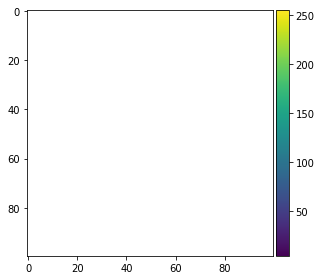

In [47]:
import skimage as sk
sk.io.imshow(images_train[0])

In [46]:
labels_predict[0]

array([1., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [97]:
predict = model.predict([images_test[0:1],labels_test[0:1],issame_in[0:1]])
predict

array([[0.6868594, 0.7891156]], dtype=float32)

### Evaluate it on the test dataset: one shot learning